Имеется простейшая $ n $ - канальная СМО с $ m $ местами в очереди; Итенсивность потока заявок $ \lambda $, потока обслуживания $ \mu $. Время пребывания заявки в очереди ограничено некоторым случайным сроком $ T $, распределенным по показательному закону с параметром $ v $. Если по истечению времени $ T $ заявка не была передана на обслуживание, она покидает СМО необслуженной.

# Задание

Построить имитационную модель СМО. Сравнить характеристики СМО, полученные в результате моделирования, с теоретическими характеристиками (финальные вероятности состояний, абсолютная пропускная способность, вероятность отказа, средние число заявок в СМО, среднее число заявок в очереди, среднее время пребывания заявки в СМО, среднее время пребывания заявки в очереди, среднее число занятых каналов).
Продемонстрировать работоспособность модели с помощью графиков и построить графики, показывающие установку стационарного режима СМО. Исследовать СМО при различных параметрах $ n $, $ m $, $  \lambda $, $ \mu $.


In [417]:
import numpy as np
import simpy as sp
import statistics as st
import matplotlib.pyplot as plt
import prettytable as pt

# СМО
Системой массового обслуживания (СМО) называется любая система для
выполнения заявок, поступающих в неё в случайные моменты времени. 

QueueSystem - класс, который представляет СМО.

In [418]:
class QueueSystem(object):
    def __init__(self, env, n, m, _lambda, mu, v):
        # Характеристики системы
        self.n = n
        self.m = m
        self._lambda = _lambda
        self.mu = mu
        self.v = v

        # Колличество завок в системе
        self.counts = []
        # Среднее время ожидания в qs
        self.times = []
        # Колличество завок в очереди
        self.queue_counts = []
        # Среднее время ожидания в очереди
        self.queue_times = []

        # Обработанные заявки
        self.serve_items = []
        # Откланенные заявки заявки
        self.reject_items = []

        self.env = env
        self.resources = sp.Resource(env, n)

    def serve(self):
        yield self.env.timeout(np.random.exponential(1.0 / self.mu))

    def wait(self):
        yield self.env.timeout(np.random.exponential(1.0 / self.v))

    def get_workload(self):
        return self.resources.count

    def get_queue_len(self):
        return len(self.resources.queue)

    def start(self, action):
        while True:
            yield self.env.timeout(np.random.exponential(1 / self._lambda))
            self.env.process(action(self))

Serve - функция которая имитирует работу СМО.

In [419]:
def serve(queue_system):
  queue_len = queue_system.get_queue_len()
  qn_count = queue_system.get_workload()
  with queue_system.resources.request() as request:
    queue_current_len = queue_system.get_queue_len()
    qn_current_count = queue_system.get_workload()
    queue_system.queue_counts.append(queue_len)
    queue_system.counts.append(queue_len + qn_count)
    if queue_current_len <= queue_system.m:
      start = queue_system.env.now
      response = yield request | queue_system.env.process(queue_system.wait())
      queue_system.queue_times.append(queue_system.env.now - start)
      if request in response:
        yield queue_system.env.process(queue_system.serve())
        queue_system.serve_items.append(queue_current_len + qn_current_count)
      else:
        queue_system.reject_items.append(queue_current_len + qn_current_count)
      queue_system.times.append(queue_system.env.now - start)
    else:
      queue_system.reject_items.append(queue_system.n + queue_system.m + 1)
      queue_system.times.append(0)
      queue_system.queue_times.append(0)

# Теоретические вероятности:

При достаточно большом времени протекания процессов в системе (при ) могут устанавливаться вероятности состояний, не зависящие от времени, которые называются финальными вероятностями, т.е. в системе устанавливается стационарный режим. \
Смысл финальных вероятностей состоит в том, что они равны среднему относительному времени нахождения системы в данном состоянии.

Финальные вероятности:

$ \rho = \lambda / \mu $

$ \beta = v / \mu $

$ p_{0} = (1 + \frac{\rho}{1!} + \frac{\rho^2}{2!} + ...+ \frac{\rho^n}{n!} + \frac{\rho^n}{n!} * \sum_{i = 1}^m \frac{\rho^i}{\prod_{l = 1}^i (n + l\beta)})^{-1} $

$ p_{k} = \frac{\rho^k}{k!} * p_{0}, (k = \bar{1, n}) $ 

$ p_{n + i} = p_{n} * \frac{\rho^i}{\prod_{l = 1}^i (n + l\beta)}, (i = \bar{1, m}) $ 

In [420]:
def get_theoretical_final_probabilities(n, m, _lambda, mu, v):
  rho = _lambda / mu
  beta = v / mu
  p_0 = (np.sum([(rho ** i) / np.math.factorial(i) for i in range(n + 1)]) + ((rho ** n) / np.math.factorial(n)) * (np.sum([(rho ** i) / (np.prod([n + l * beta for l in range(1, i + 1)])) for i in range(1, m + 1)]))) ** -1
  final_probabilities = [p_0] + [((rho ** k) / np.math.factorial(k)) * p_0 for k in range(1, n + 1)]
  p_n = final_probabilities[-1]
  final_probabilities += [((rho ** i) / (np.prod([n + l * beta for l in range(1, i + 1)]))) * p_n for i in range(1, m + 1)]
  return final_probabilities

Вероятность образования очереди

$ p_{q} = \sum_{i = 0}^{m - 1} p_{n + i} $

In [421]:
def get_theoretical_queue_probability(n, m, final_probabilities):
  return np.sum([final_probabilities[n + i] for i in range(0, m)])

Вероятность отказа

$ p_{r} = p_{n + m} $

In [422]:
def get_theoretical_reject_probability(n, m, final_probabilities):
  return final_probabilities[n + m]

Относитальная пропускная способность СМО – отношение среднего числа заявок,
обслуживаемых СМО в единицу времени, к среднему числу поступивших за это же время заявок.


$ Q = 1 - p_{q} $

In [423]:
def get_theoretical_relative_bandwidth(reject_probability):
  return 1 - reject_probability

Абсолютная пропускная способность СМО – среднее число заявок, которое сможет обслужить
СМО в единицу времени.

$ A = Q \lambda $

In [424]:
def get_theoretical_absolute_bandwidth(relative_bandwidth, _lambda):
  return relative_bandwidth * _lambda

Среднее число элементов в очереди

$ L_{q} = \sum_{i = 1}^{m} i * p_{n + i} $

In [425]:
def get_theoretical_average_queue_items_count(n, m, final_probabilities):
  return np.sum([i * final_probabilities[n + i] for i in range(1, m + 1)])

Среднее число элементов в СМО

$ L_{qs} = \sum_{k = 1}^{n} k * p_{k} + \sum_{i = 1}^{m} (n + i) * p_{n + i} $

In [426]:
def get_theoretical_average_queue_system_items_count(n, m, final_probabilities):
  return np.sum([k * final_probabilities[k] for k in range(1, n + 1)]) + np.sum([(n + i) * final_probabilities[n + i] for i in range(1, m + 1)])

Среднее число активных каналов

$ k = Q * \rho $

In [427]:
def get_theoretical_average_active_channal_count(relative_bandwidth, rho):
  return relative_bandwidth * rho

Среднее время пребывания элемента в очереди

$ T_{q} = L_{q} / \lambda $

In [428]:
def get_theoretical_average_queue_items_time(reject_probability, _lambda):
  return reject_probability / _lambda

Среднее время пребывания элемента в СМО

$ T_{qs} = L_{qs} / \lambda $

In [429]:
def get_theoretical_average_queue_system_items_time(average_queue_system_items_count, _lambda):
  return average_queue_system_items_count / _lambda

In [430]:
def get_theoretical_info(n, m, _lambda, mu, v):
  final_probabilities = get_theoretical_final_probabilities(n, m, _lambda, mu, v)
  queue_probability = get_theoretical_queue_probability(n, m, final_probabilities)
  reject_probability = get_theoretical_reject_probability(n, m, final_probabilities)
  relative_bandwidth = get_theoretical_relative_bandwidth(reject_probability)
  absolute_bandwidth = get_theoretical_absolute_bandwidth(relative_bandwidth, _lambda)
  average_queue_items_count = get_theoretical_average_queue_items_count(n, m, final_probabilities)
  average_queue_system_items_count = get_theoretical_average_queue_system_items_count(n, m, final_probabilities)
  average_active_channal_count = get_theoretical_average_active_channal_count(relative_bandwidth, _lambda / mu)  
  average_queue_items_time = get_theoretical_average_queue_items_time(average_queue_items_count, _lambda)
  average_queue_system_items_time = get_theoretical_average_queue_system_items_time(average_queue_system_items_count, _lambda)
  return final_probabilities, queue_probability, reject_probability, relative_bandwidth, absolute_bandwidth, average_queue_items_count, average_queue_system_items_count, average_active_channal_count, average_queue_items_time, average_queue_system_items_time

# Эмперические вероятности:

Финальные вероятности

In [431]:
def get_experimental_final_probabilities(queue_system):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return [(len(items[items == i]) / len(items)) for i in range(1, queue_system.n + queue_system.m + 2)]

Вероятность образования очереди

In [432]:
def get_experimental_queue_probability(queue_system):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return np.sum([(len(items[items == i]) / len(items)) for i in range(1, queue_system.n + queue_system.m + 2) if i > queue_system.n and i < queue_system.n + queue_system.m + 1])

Вероятность отказа

In [433]:
def get_experimental_reject_probability(queue_system):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return (len(items[items == queue_system.n + queue_system.m + 1]) / len(items))

Относитальная пропускная способность

In [434]:
def get_experimental_relative_bandwidth(queue_system):
  return 1 - get_experimental_reject_probability(queue_system)

Абсолютная пропускная способность

In [435]:
def get_experimental_absolute_bandwidth(queue_system):
  return get_experimental_relative_bandwidth(queue_system) * queue_system._lambda

Среднее число элементов в очереди

In [436]:
def get_experimental_average_queue_items_count(queue_system):
  return st.mean(queue_system.queue_counts)

Среднее число элементов в СМО

In [437]:
def get_experimental_average_queue_system_items_count(queue_system):
  return st.mean(queue_system.counts)

Среднее число активных каналов

In [438]:
def get_experimental_average_active_channal_count(queue_system):
  return get_experimental_relative_bandwidth(queue_system) * queue_system._lambda / queue_system.mu

Среднее время пребывания элемента в очереди

In [439]:
def get_experimental_average_queue_items_time(queue_system):
  return st.mean(queue_system.queue_times)

Среднее время пребывания элемента в СМО

In [440]:
def get_experimental_average_queue_system_items_time(queue_system):
  return st.mean(queue_system.times)

In [441]:
def get_experimental_info(queue_system):
  final_probabilities = get_experimental_final_probabilities(queue_system)
  queue_probability = get_experimental_queue_probability(queue_system)
  reject_probability = get_experimental_reject_probability(queue_system)
  relative_bandwidth = get_experimental_relative_bandwidth(queue_system)
  absolute_bandwidth = get_experimental_absolute_bandwidth(queue_system)
  average_queue_items_count = get_experimental_average_queue_items_count(queue_system) 
  average_queue_system_items_count = get_experimental_average_queue_system_items_count(queue_system) 
  average_active_channal_count = get_experimental_average_active_channal_count(queue_system) 
  average_queue_items_time = get_experimental_average_queue_items_time(queue_system) 
  average_queue_system_items_time = get_experimental_average_queue_system_items_time(queue_system)
  return final_probabilities, queue_probability, reject_probability, relative_bandwidth, absolute_bandwidth, average_queue_items_count, average_queue_system_items_count, average_active_channal_count, average_queue_items_time, average_queue_system_items_time

# Графики

In [442]:
def plot_queue_system_probabilities(queue_system, theoretical_probabilities, interval_count):
  intervals = np.array_split(queue_system.counts, interval_count) 
  for i in range(1, len(intervals)):
    intervals[i] = np.append(intervals[i], intervals[i - 1])
  for i in range (len(theoretical_probabilities)):
    interval_probabilities = []
    for interval in intervals:
      interval_probabilities.append(len(interval[interval == i]) / len(interval))
    plt.figure(figsize=(5, 5))
    plt.bar(range(len(interval_probabilities)), interval_probabilities)
    plt.title(f"Probabilitiy {i}")
    plt.axhline(y = theoretical_probabilities[i], xmin = 0, xmax = len(interval_probabilities), color='red')
    plt.show()

In [443]:
def plot_histograms(theoretical_probabilities, experimental_probabilities):
    plt.style.use('default')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
    
    ax1.set_title('Теоретические финальные вероятности')
    ax1.bar(range(len(theoretical_probabilities)), theoretical_probabilities, width = 0.2)
    
    ax2.set_title('Эмпирические финальные вероятности')
    ax2.bar(range(len(experimental_probabilities)), experimental_probabilities, width = 0.2)

    ax3.set_title('Финальные вероятности')
    ax3.bar(range(len(theoretical_probabilities)), theoretical_probabilities - experimental_probabilities, width = 0.3)
    ax3.axhline(y = 0, xmin = 0, xmax = len(theoretical_probabilities), color='red')
    
    plt.show()

# Запуск СМО:

In [444]:
def run_qs(n, m, _lambda, mu, v, time, interval_count, _round):
  env = sp.Environment()
  queue_system = QueueSystem(env, n, m, _lambda, mu, v)
  env.process(queue_system.start(serve))
  env.run(until = time)
  
  theoretical_info = (get_theoretical_info(n, m, _lambda, mu, v))
  experimental_info = (get_experimental_info(queue_system))
  
  final_probabilities_info = pt.PrettyTable()
  final_probabilities_info.add_column("Теоретические финальные вероятности", np.around(theoretical_info[0], _round))
  final_probabilities_info.add_column("Эмпирические финальные вероятности", np.around(experimental_info[0], _round))
  print(final_probabilities_info)
  
  field_names = ["Вероятность образования очереди", 
                 "Вероятность отказа", 
                 "Относитальная пропускная способность", 
                 "Абсолютная пропускная способность", 
                 "Среднее число элементов в очереди",
                 "Среднее число элементов в СМО",
                 "Среднее число активных каналов",
                 "Среднее время пребывания элемента в очереди",
                 "Среднее время пребывания элемента в СМО"]
  
  for index, value in enumerate(field_names):
    info = pt.PrettyTable()
    info.field_names = ["Исследование", value]
    info.add_row(["Теоретическое", np.around(theoretical_info[index + 1], _round)])
    info.add_row(["Эмпирическое", np.around(experimental_info[index + 1], _round)])
    print(info)
    
  plot_histograms(np.around(theoretical_info[0], _round), np.around(experimental_info[0], _round))
  plot_queue_system_probabilities(queue_system, theoretical_info[0], interval_count)

Тест 1
+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|             0.0874335626            |            0.0807329372            |
|             0.1748671253            |            0.1724499476            |
|             0.1748671253            |            0.1754456039            |
|             0.1589701139            |            0.1641619652            |
|             0.1324750949            |            0.1339557641            |
|             0.1019039192            |            0.1036996355            |
|             0.0727885137            |            0.0724449548            |
|             0.0485256758            |            0.0478306456            |
|             0.0303285474            |            0.031853812             |
|             0.017840322             |            0.0174247341      

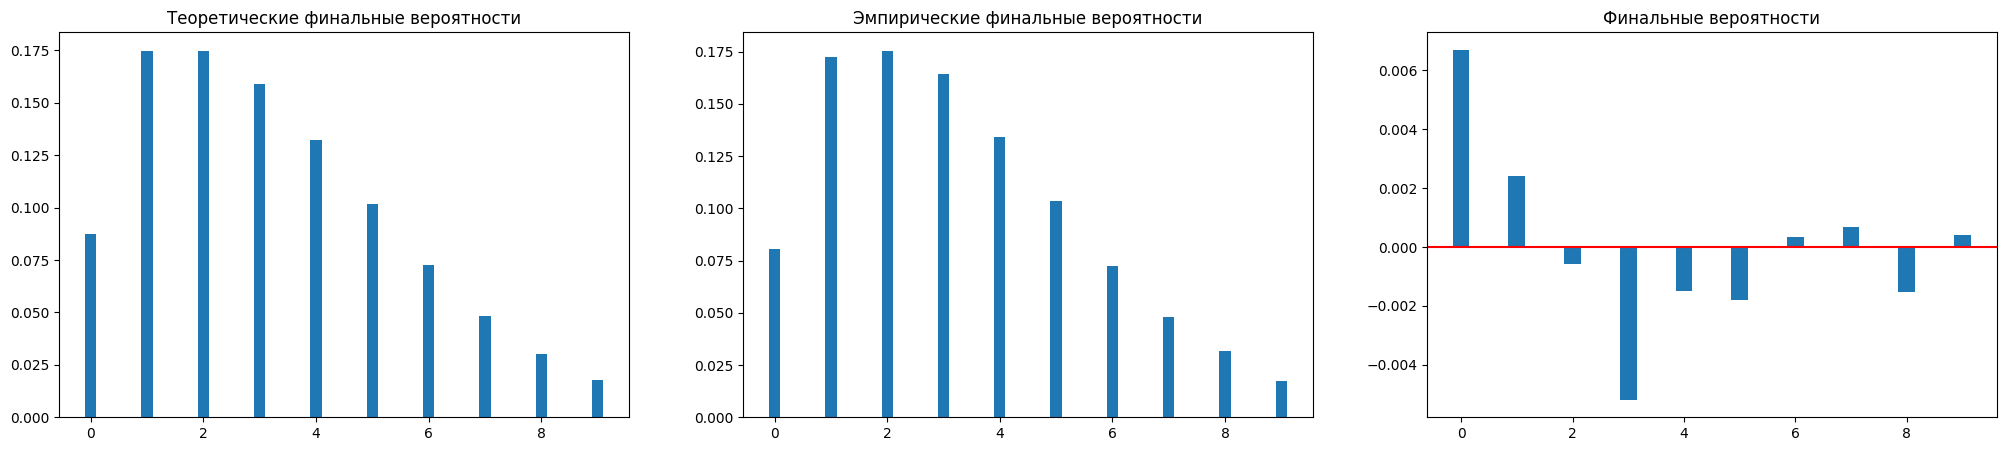

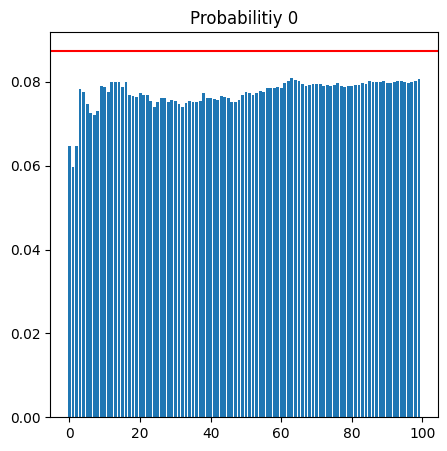

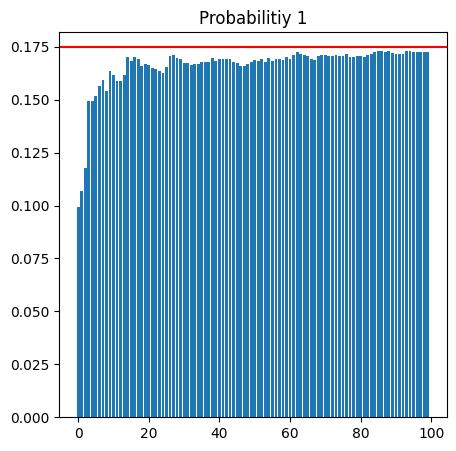

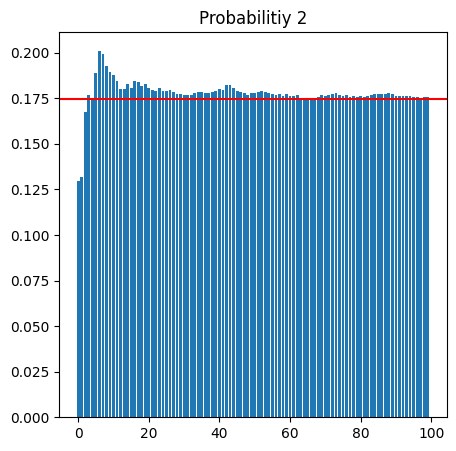

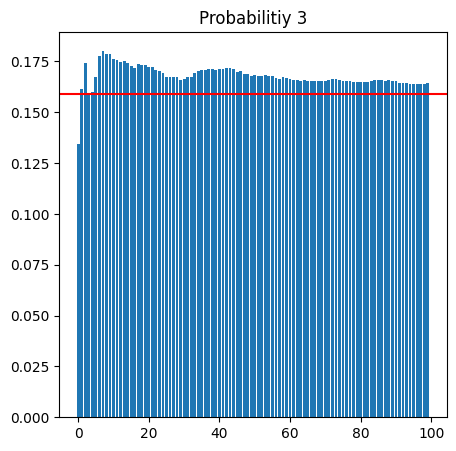

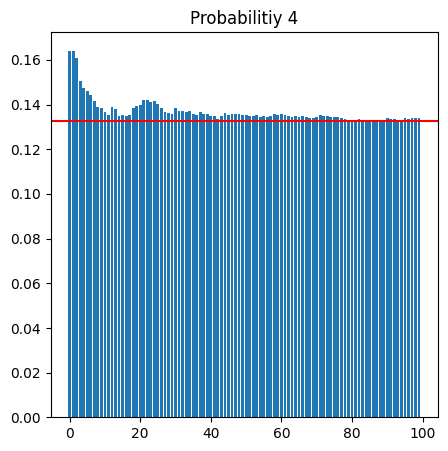

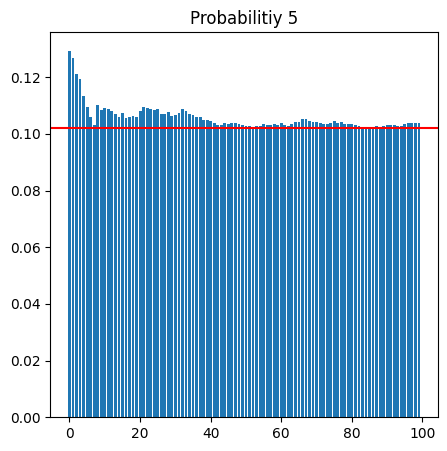

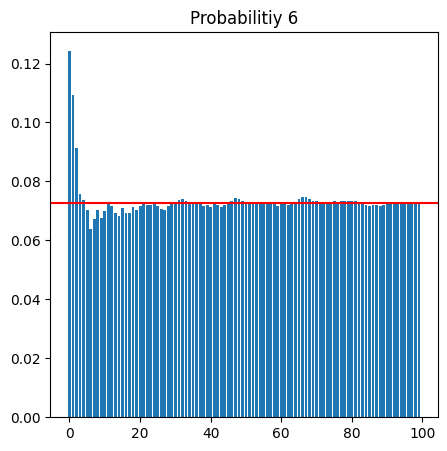

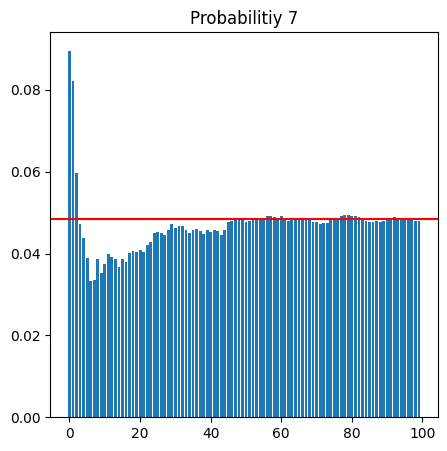

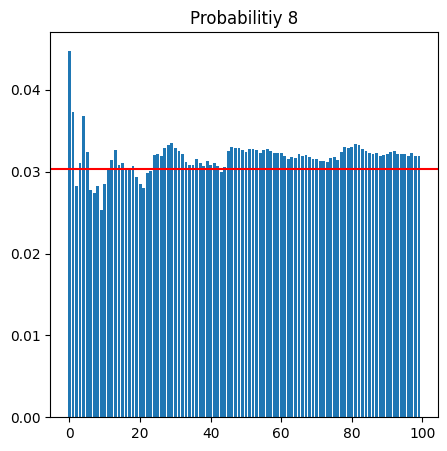

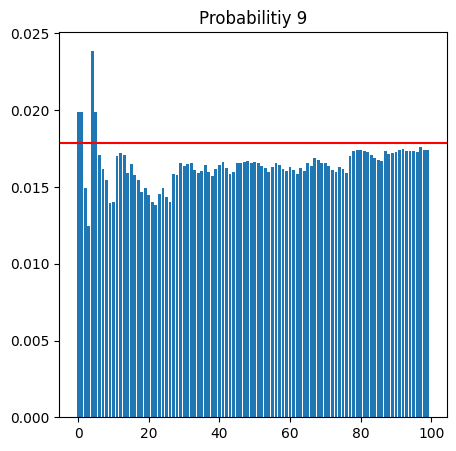

In [451]:
print("Тест 1")
run_qs(2, 7, 10, 5, 1, 2000, 100, 10)

In [452]:
# print("Тест2")
# run_qs(5, 10, 100, 10, 1, 1000, 100, 10)

In [453]:
# print("Тест 3")
# run_qs(2, 1, 10, 5, 1, 1000, 100, 10)